In [1]:
from epynet import Network
import numpy as np
import math as m
import operator
#import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../src/')
from network_grouping import *

In [2]:
inp = "../input/santaizabel0118.inp"
n_groups = 20

net = Network(inp)
keys = net.nodes.keys()   # List with uids of each node
all_nodes = [net.nodes[key] for key in keys]   # List of all possible nodes 
net.ep.ENclose()
    
[all_nodes.remove(n) for n in all_nodes if n.node_type != "Junction"]  # Remove elements that are not Junction in all_nodes
nodes = [n.uid for n in all_nodes] 
n_nodes = len(nodes)

print n_nodes

442


In [3]:
# Get y from csv

df = pd.read_csv('st_izabel-0118_20groups.csv')
nodes_groups = np.asarray(df)

nodes = [str(nodes_groups[i,0]) for i in range(nodes_groups.shape[0])]
groups = nodes_groups[:,1]
y = zip(nodes, nodes_groups[:,1])
y = dict(y)

In [31]:
def node_dif_pressures_f(inp, leak_flow, y, i):
    
    y_dif_sensor = []
    coef_emitter = 0.5
    leak_flow = leak_flow % 3.6  # to converte m³/h to l/s
    
    sensor = nodes_next_center(inp, y, i) # Take a sensor of group    
    node_list = [key for key in y.keys() if y[key] == i] # Take the nodes in this group
    n_nodes_group = len(node_list)
        
    for j in range(n_nodes_group): # node by node 

        y_simulated_node = simulation(inp, sensorIds = [str(node_list[j])], nodeIds = [str(node_list[j])]) # take the normal pressure in the node
        y_simulated_node = np.mean(y_simulated_node)
        
        emitter = np.divide(leak_flow, y_simulated_node ** coef_emitter)
        
        # Pressure at sensors
        y_simulated_sensor = simulation(inp, sensorIds=sensor, nodeIds=[str(node_list[j])])
        y_simulated_leak_sensor = simulation(inp, emitter= emitter, sensorIds=sensor, nodeIds=[str(node_list[j])])

        y_dif_sensor.append(np.mean((y_simulated_sensor - y_simulated_leak_sensor))) # Mean at time

    node_value_group = [[node_list[indice], y_dif_sensor[indice]] for indice in range(n_nodes_group)]
    node_value_group = dict(node_value_group)
    node_value_group = sorted(node_value_group.items(), key=operator.itemgetter(1))  # Put the values in ascending order

    return node_value_group

In [25]:
def node_dif_pressures_e(inp, emitter, y, i):

    y_dif_sensor = []

    sensor = nodes_next_center(inp, y, i) # Take a sensor of group    
    node_list = [key for key in y.keys() if y[key] == i] # Take the nodes in this group
    n_nodes_group = len(node_list)
        
    for j in range(n_nodes_group): # node by node 

        # Pressure at sensors
        y_simulated_sensor = simulation(inp, sensorIds=sensor, nodeIds=[str(node_list[j])])
        y_simulated_leak_sensor = simulation(inp, emitter= emitter, sensorIds=sensor, nodeIds=[str(node_list[j])])

        y_dif_sensor.append(np.mean((y_simulated_sensor - y_simulated_leak_sensor))) # Mean at time

    node_value_group = [[node_list[indice], y_dif_sensor[indice]] for indice in range(n_nodes_group)]
    node_value_group = dict(node_value_group)
    node_value_group = sorted(node_value_group.items(), key=operator.itemgetter(1))  # Put the values in ascending order

    return node_value_group

In [27]:
# Separate the values in node_value according specifics range of numbers

def separate_degrade(node_value, values):
    group = []
    cont = 0
    node = 0
    i = 0

    while node < len(node_value) and i < len(values):
        if node_value[node][1] < values[i]: 
            cont = cont + 1
            node = node + 1
        else:    
            group = group + cont*[i]
            i = i + 1

    n_residual = len(node_value) - len(group)   # Number of nodes that are without group

    if n_residual > 0:
        group = group + n_residual*[i + 1] 

    node_degrade = dict([[node_value[index][0], group[index]] for index in range(len(node_value))])

    return node_degrade

In [34]:
def graph_degrade(inp, y, n_groups, node_degrade, values):
    net = inp_to_graph(inp)
    cmap = plt.cm.get_cmap('PuBu', len(values))

    for i_tone in range(len(values)):    
        node_list = [key for key in node_degrade.keys() if node_degrade[key] == i_tone] # List of all nodes in i_groups

        draw_networkx(net, with_labels=False, pos=net.graph['COORDINATES'], node_size=60, nodelist = node_list,
                    node_color = cmap(i_tone))

    # Center
    for i in range(n_groups):
        center = center_group(inp, y, i)
        plt.scatter(center[:,0], center[:,1], marker="8", linewidths = 20, color= 'black')


    fig_size = [0,0]
    fig_size[0] = 7
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.title ("Leak flow in each node")
    fig_size
    #plt.savefig(str(inp)+ str(n_groups) + 'groups.png')
    plt.show()

In [26]:
emitter = 0.002
node_value = []

for i in range(n_groups):   
    node_value_group = node_dif_pressures_e(inp, emitter, y, i)
    node_value = node_value + node_value_group
    
values = [0.001, 0.01, 0.05, 0.1, 0.5, 1]

node_value = dict(node_value)
node_value = sorted(node_value.items(), key=operator.itemgetter(1))  # Put the values in ascending order

NameError: name 'separate_degrade' is not defined

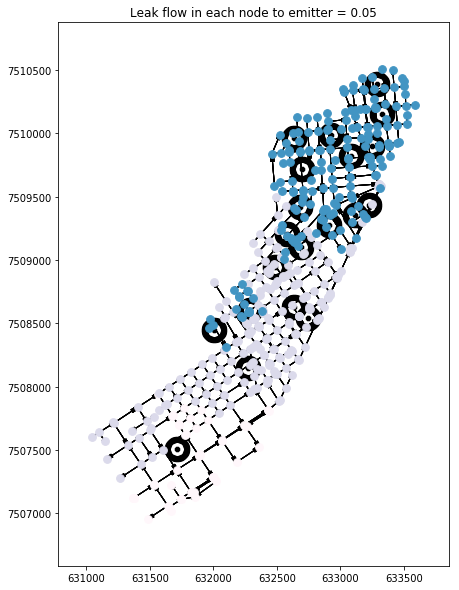

In [29]:
node_degrade = separate_degrade(node_value, values)

graph_degrade(inp, y, n_groups, node_degrade, values)

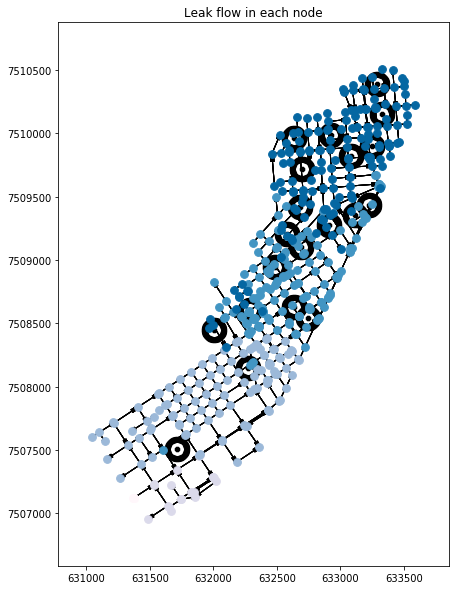

In [38]:
emitter = 0.05
node_value = []

for i in range(n_groups):   
    node_value_group = node_dif_pressures_e(inp, emitter, y, i)
    node_value = node_value + node_value_group
    
values = [0.001, 0.01, 0.05, 0.1, 0.5, 1]

node_value = dict(node_value)
node_value = sorted(node_value.items(), key=operator.itemgetter(1))  # Put the values in ascending order

node_degrade = separate_degrade(node_value, values)

graph_degrade(inp, y, n_groups, node_degrade, values)

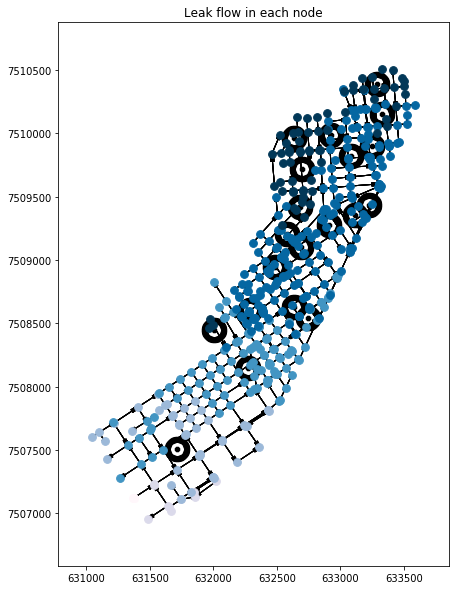

In [39]:
emitter = 0.1
node_value = []

for i in range(n_groups):   
    node_value_group = node_dif_pressures_e(inp, emitter, y, i)
    node_value = node_value + node_value_group
    
values = [0.001, 0.01, 0.05, 0.1, 0.5, 1]

node_value = dict(node_value)
node_value = sorted(node_value.items(), key=operator.itemgetter(1))  # Put the values in ascending order

node_degrade = separate_degrade(node_value, values)

graph_degrade(inp, y, n_groups, node_degrade, values)

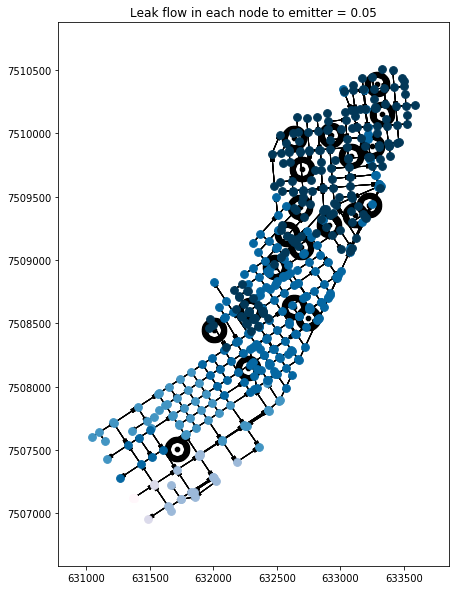

In [32]:
leak_flow = 1
node_value = []

for i in range(n_groups):   
    node_value_group = node_dif_pressures_f(inp, leak_flow, y, i)
    node_value = node_value + node_value_group
    
values = [0.001, 0.01, 0.05, 0.1, 0.5, 1]

node_value = dict(node_value)
node_value = sorted(node_value.items(), key=operator.itemgetter(1))  # Put the values in ascending order

node_degrade = separate_degrade(node_value, values)

graph_degrade(inp, y, n_groups, node_degrade, values)

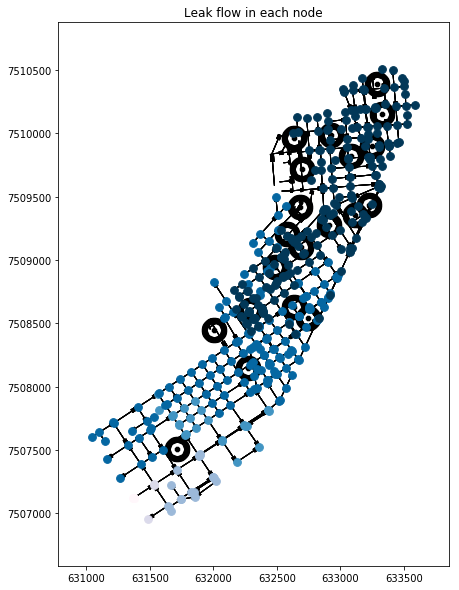

In [36]:
leak_flow = 5
node_value = []

for i in range(n_groups):   
    node_value_group = node_dif_pressures_f(inp, leak_flow, y, i)
    node_value = node_value + node_value_group
    
values = [0.001, 0.01, 0.05, 0.1, 0.5, 1]

node_value = dict(node_value)
node_value = sorted(node_value.items(), key=operator.itemgetter(1))  # Put the values in ascending order

node_degrade = separate_degrade(node_value, values)

graph_degrade(inp, y, n_groups, node_degrade, values)